# data preprocessing

In [32]:
import io
import json
import os
import pickle
import re
from collections import Counter
from shutil import rmtree

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorboard.plugins import projector
from PIL import Image
from soynlp.normalizer import repeat_normalize
from hanspell import spell_checker
# from tqdm.notebook import tqdm
from tqdm import tqdm
from wordcloud import WordCloud

from tokenizer import Tokenizer
from utils import load_json, save_pickle


cfg = load_json("config.json")

In [2]:
from khaiii_utils import get_khaiii_api, pos_text, stemming_text
api = get_khaiii_api('/mnt/subdisk/workspace/khaiii/build/share/khaiii')

In [3]:
df = pd.read_excel("resource/ine_coment.xlsx")
df.head()

,title,desc,name,time,comment
0,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Miyeon OvO,2021-11-15 11:52:24,난 이세돌에 그렇게까지 스며들지 않았다고 생각했는데 석탄빼고 다 아는건 도대체 무엇...
1,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Ahnung Habe,2021-11-15 11:49:37,짹짹 맛있어요
2,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,시나럽,2021-11-15 11:39:28,새로운 참새는 언제나 환영이라구~
3,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,정담은,2021-11-15 11:02:29,"1:22 ""나를 버리기"""
4,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Dozer,2021-11-15 10:51:33,호윽시 2:18에 부디 커버한거 어디서 들을수있나요 ㅠㅠ


In [4]:
def normalize(text):
    text = text.replace("_x000D_", " ")
    text = text.replace("\n", " ")
    text = text.replace("넴", "님")
    text = text.replace("넘", "님")
    text = text.replace("팅아", "킹아")
    text = text.replace("는데", "다")
    text = text.replace("아니네", "아이네")
    text = text.replace("님모", "너무")
    text = text.replace("해미네", "햄이네")
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    text = re.sub(r'\d+(:\d+)+|[^ 가-힣0-9]', r' ', text)
    text = repeat_normalize(text, 3)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text.strip()

df = df[df['name'] != '아이네 INE']
df['comment'] = df['comment'].apply(normalize)
df = df[df['comment'].str.len() > 1]
df.head(5)

,title,desc,name,time,comment
0,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Miyeon OvO,2021-11-15 11:52:24,난 이세돌에 그렇게까지 스며들지 않았다고 생각했다 석탄빼고 다 아는건 도대체 무엇
1,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Ahnung Habe,2021-11-15 11:49:37,짹짹 맛있어요
2,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,시나럽,2021-11-15 11:39:28,새로운 참새는 언제나 환영이라구
3,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,정담은,2021-11-15 11:02:29,나를 버리기
4,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Dozer,2021-11-15 10:51:33,호윽시 에 부디 커버한거 어디서 들을수있나요


In [5]:
def spell_check(text):
#     try:
#         text = spell_checker.check(text).checked
#     except:
#         print(text)
    text = spell_checker.check(text).checked
    
    text = re.sub("둘 기|두 기", '둘기', text)
    text = re.sub("아키 데이터", '아키네이터', text)
    text = re.sub("아 ?이 ?네", "아이네", text)
    text = re.sub("징 ?버 ?거|징벌 거", "징버거", text)
    text = re.sub("릴 ?파|릴이", "릴파", text)
    text = re.sub("주 ?르 ?르", "주르르", text)
    text = re.sub("고 ?세 ?구", "고세구", text)
    text = re.sub("비 ?챤|비참|비천", "비챤", text)
    text = re.sub("글 라모스|글 ?라 ?도 ?스", "글라도스", text)
    text = re.sub("준내", "쥰내", text)
    text = re.sub("나그네인 저", "느그레인저", text)
    text = re.sub("센 ?세 ?이", "겐세이", text)
    text = re.sub("어멍 어스", "어몽어스", text)
    text = re.sub("레 ?게 ?노", "레게노", text)
    text = re.sub("셋소 마루", "셋쇼마루", text)
    text = re.sub("네 절", "뇌절", text)
    text = re.sub("깨우", "깨부", text)
    text = re.sub("몰리겠네", "몰루겠네", text)
    text = re.sub("존 번", "존버", text)
    
    return text

In [6]:
idxes = [*range(len(df))]
error_idxes = []

while idxes != []:
    for i in tqdm(idxes):
        try:
            df.iloc[i, -1] = spell_check(df.iloc[i, -1])
        except:
            error_idxes.append(i)
    
    idxes = error_idxes
    error_idxes = []
    
    print(len(idxes))

df = df[df.comment != ""]

df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.84it/s]

1
0


,title,desc,name,time,comment
0,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Miyeon OvO,2021-11-15 11:52:24,난 이세돌에 그렇게까지 스며들지 않았다고 생각했다 석탄 빼고 다 아는 건 도대체 무엇
1,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Ahnung Habe,2021-11-15 11:49:37,짹짹 맛있어요
2,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,시나럽,2021-11-15 11:39:28,새로운 참새는 언제나 환영이라고
3,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,정담은,2021-11-15 11:02:29,나를 버리기
4,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Dozer,2021-11-15 10:51:33,호윽시 에 부디 커버한 거 어디서 들을 수 있나요


In [7]:
pos_tagged_corpus = pos_text(df.comment, api)
df['processed_comment'] = stemming_text(pos_tagged_corpus)

In [8]:
df['processed_comment'] = df['processed_comment'].apply(
    lambda x: ' '.join(
        [
            w.split('/')[0] 
            for w in x.split() 
            if w.split('/')[1] in ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'MAJ']
        ]
    )
)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Miyeon OvO,2021-11-15 11:52:24,난 이세돌에 그렇게까지 스며들지 않았다고 생각했다 석탄 빼고 다 아는 건 도대체 무엇,이세돌 그렇 스며들다 않다 생각하다 석탄 빼다 다 알다 도대체
1,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Ahnung Habe,2021-11-15 11:49:37,짹짹 맛있어요,짹짹 맛있
2,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,시나럽,2021-11-15 11:39:28,새로운 참새는 언제나 환영이라고,새롭 참새 언제나 환영
3,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,정담은,2021-11-15 11:02:29,나를 버리기,버리다
4,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Dozer,2021-11-15 10:51:33,호윽시 에 부디 커버한 거 어디서 들을 수 있나요,호윽시 부디 커버 하다 듣다 있다


In [9]:
def normalize_word(text):
    result = []
    
    for word in text.split():
        if word.startswith("좋"):
            word = "좋다"
        elif word.startswith("싫"):
            word = "싫다"
        elif word in ['귀엽', '귀다', '귀여우다', '귀여워하다', '귀이다', '귀여웤다', '귀엽뽀짝하다', '귀엽잖', '귀엽넼다', '귀하', '귀여다', '귀엽네', '귀엽땨다', '귀', '귀염', '귀여', '귀여우시다']:
            word = "귀엽다"
        elif word == "없":
            word = "없다"
        elif word in ['진짜웃기넼다', '진짴', '진자', '진', '진짜하다']:
            word = "진짜"
        elif "노래뱅" in word:
            word = "노래뱅"
        elif word.startswith("노래"):
            word = "노래" if word == "노래하다" else word
        elif "아이네" in word:
            word = "아이네"
        elif "햄이네" in word:
            word = "햄이네"
        elif word in ['와꿋', "와꾸텽", "와꾸텽하다", "왁구텽", "왁굳텽", "왁구텽다"]:
            word = "왁굳형"
        elif "비둘기" in word:
            word = "비둘기"
        
        result.append(word)
    
    return " ".join(result)

In [10]:
df['processed_comment'] = df['processed_comment'].apply(normalize_word)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Miyeon OvO,2021-11-15 11:52:24,난 이세돌에 그렇게까지 스며들지 않았다고 생각했다 석탄 빼고 다 아는 건 도대체 무엇,이세돌 그렇 스며들다 않다 생각하다 석탄 빼다 다 알다 도대체
1,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Ahnung Habe,2021-11-15 11:49:37,짹짹 맛있어요,짹짹 맛있
2,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,시나럽,2021-11-15 11:39:28,새로운 참새는 언제나 환영이라고,새롭 참새 언제나 환영
3,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,정담은,2021-11-15 11:02:29,나를 버리기,버리다
4,아이네 방송 밈 알려드림,20211030 아이네 밈 파헤치기! 아이네 방송 밈 알려드림 아이네 생방송: h...,Dozer,2021-11-15 10:51:33,호윽시 에 부디 커버한 거 어디서 들을 수 있나요,호윽시 부디 커버 하다 듣다 있다


In [11]:
df.to_excel("resource/preprecessed_ine_coment.xlsx", index=None)

In [12]:
df = pd.read_excel("resource/preprecessed_ine_coment.xlsx")

# draw wordcloud

In [13]:
all_tokens = sum(df['processed_comment'].apply(lambda x: x.split()), [])

In [14]:
counter = Counter(all_tokens)

counter.most_common(10)

[('아이네', 1533),
 ('너무', 1150),
 ('좋다', 1044),
 ('보다', 942),
 ('하다', 829),
 ('귀엽다', 652),
 ('진짜', 627),
 ('있다', 471),
 ('킹아', 428),
 ('영상', 421)]

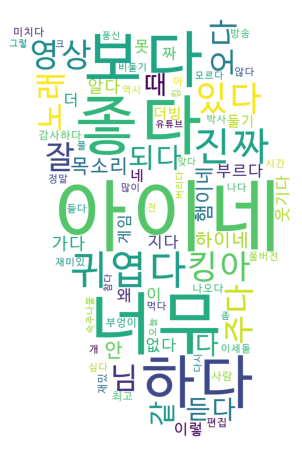

In [15]:
bgimg = Image.open('resource/wakdoo.png')
mask = np.array(bgimg)

wc = WordCloud(font_path="resource/D2Coding.ttf",background_color="white", max_font_size=200, mask=mask)
cloud = wc.generate_from_frequencies(dict(counter.most_common(80)))
cloud.to_file("resource/wordcloud.png")

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# tokenizer

In [16]:
tokens = ["[PAD]", "[UNK]"] + [t[0] for t in counter.most_common(len(counter))]

save_pickle({k: i for i, k in enumerate(tokens)}, "resource/tokenizer.pkl")

In [17]:
tokenizer = Tokenizer("resource/tokenizer.pkl")

In [18]:
sample_text = df.iloc[0, -1]

print(sample_text)
print(tokenizer.encode(sample_text))

이세돌 그렇 스며들다 않다 생각하다 석탄 빼다 다 알다 도대체
[51, 73, 2109, 60, 254, 794, 795, 20, 27, 978]


# word 2 Vec

## data setting

In [19]:
targets, contexts, labels = [], [], []

sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(tokenizer.vocab_size)

In [20]:
for text in tqdm(df.processed_comment):
    sequence = tokenizer.encode(text)
    if len(sequence) < cfg['num_negative_samples'] * 2 + 1:
        continue
    
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
        sequence,
        vocabulary_size=tokenizer.vocab_size,
        sampling_table=sampling_table,
        window_size=cfg['window_size'],
        negative_samples=0
    )

    for target_word, context_word in positive_skip_grams:
        context_class = tf.expand_dims(tf.constant([context_word], dtype="int64"), 1)
        negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
            true_classes=context_class,
            num_true=1,
            num_sampled=cfg['num_negative_samples'],
            unique=True,
            range_max=tokenizer.vocab_size,
            seed=cfg['random_seed'],
            name="negative_sampling"
        )

        negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)

        context = tf.concat([context_class, negative_sampling_candidates], 0)
        label = tf.constant([1] + [0] * cfg['num_negative_samples'], dtype="int64")

        targets.append(target_word)
        contexts.append(context)
        labels.append(label)

100%|█████████████████████████████████████████████████████████████████████████████| 8287/8287 [00:07<00:00, 1074.49it/s]


In [21]:
targets = np.array(targets)
contexts = np.array(contexts)[:,:,0]
labels = np.array(labels)

targets.shape, contexts.shape, labels.shape

((12716,), (12716, 5), (12716, 5))

In [22]:
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(cfg['batch_size'], drop_remainder=True)

print(dataset, len(dataset))

<BatchDataset shapes: (((64,), (64, 5)), (64, 5)), types: ((tf.int64, tf.int64), tf.int64)> 198


## model define

In [23]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size):
        super(Word2Vec, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        
#         self.embedding = tf.keras.layers.Embedding(
#             vocab_size,
#             embedding_size,
#         )

        self.target_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_size,
        )

        self.context_embedding = tf.keras.layers.Embedding(
            vocab_size,
            embedding_size,
        )

    def call(self, pair):
        target, context = pair
        
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)

#         word_emb = self.embedding(target)
#         context_emb = self.embedding(context)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        output = tf.einsum('be,bce->bc', word_emb, context_emb)

        return output

    def get_config(self):
        return {
            "vocab_size": self.vocab_size,
            "embedding_size": self.embedding_size,
        }

In [33]:
word2vec = Word2Vec(tokenizer.vocab_size, cfg['embedding_size'])
word2vec.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## train

In [34]:
if os.path.isdir('logs'):
    rmtree("logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs", update_freq='batch')

In [35]:
word2vec.fit(dataset, epochs=cfg['epochs'], callbacks=[tensorboard_callback], verbose=0)

## visualize

In [31]:
# %load_ext tensorboard
# %tensorboard --logdir logs

https://projector.tensorflow.org/?config=https://raw.githubusercontent.com/Nam-SW/INE_comment_analysis/main/resource/projector_config.json

업데이트 하려면 push 해아함!

In [36]:
weights = word2vec.target_embedding.get_weights()[0]
# weights = word2vec.embedding.get_weights()[0]

out_v = io.open('resource/vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('resource/metadata.tsv', 'w', encoding='utf-8')

for index, word in tokenizer.id_to_word.items():
    if index < 2:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
    
out_v.close()
out_m.close()

In [37]:
config = {
  "embeddings": [
    {
      "tensorName": "Ine word2vec",
      "tensorShape": list(weights[2:].shape),
      "tensorPath": "https://raw.githubusercontent.com/Nam-SW/INE_comment_analysis/main/resource/vectors.tsv",
      "metadataPath": "https://raw.githubusercontent.com/Nam-SW/INE_comment_analysis/main/resource/metadata.tsv"
    }
  ]
}

In [38]:
with open('resource/projector_config.json', "w", encoding='utf-8') as f:
    json.dump(config, f)